# 01.10 - BEE-NOBEE - SVM Classification

## Prerequisites

- The dataset exists (if not, execute 01.01)
- The dataset features have been populated (if not, execute 01.02)


In [1]:
import warnings                              # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')            # commented out till the experiment final version,
                                             # in order to avoid missing "real" warnings 
from IPython.display import display
import kilroy_was_here                       # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import iprint
from audace.audiodataset import AudioDataset # Main class for audio dataset handling

# Experiment name will be used to prefix potential outputs
EXP_NAME = "01.10 - BEE-NOBEE - SVM Classification"

# Dataset name is the master key for dataset adressing
# Change it according to the dataset you want to process
DATASET_NAME = 'MAIN1000'

# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

[2020-09-09/21:07:50.012|36.9%|76.0%|0.28GB] ------------------------------------------------------
[2020-09-09/21:07:50.013|00.0%|76.0%|0.28GB] DATASET NAME          : MAIN1000
[2020-09-09/21:07:50.013|00.0%|76.0%|0.28GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-09-09/21:07:50.014|00.0%|76.0%|0.28GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-09-09/21:07:50.014|00.0%|76.0%|0.28GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-09-09/21:07:50.014|00.0%|76.0%|0.28GB] NB SOURCE AUDIO FILES : 48
[2020-09-09/21:07:50.015|00.0%|76.0%|0.28GB] SAMPLE RATE           : 22050
[2020-09-09/21:07:50.015|00.0%|76.0%|0.28GB] DURATION              : 1.0
[2020-09-09/21:07:50.015|00.0%|76.0%|0.28GB] OVERLAP               : 0.0
[2020-09-09/21:07:50.015|00.0%|76.0%|0.28GB] NB AUDIO CHUNKS       : 24788
[2020-09-09/21:07:50.015|00.0%|76.0%|0.28GB] ------------------------------------------------------


In [2]:
# label as no bee only if at least 50% of chunck is noisy
NOISE_THRESHOLD = 0.5

# Display cardinalities by hive attribute and binary nobee label
sql = F"""
    select distinct hive, iif(nobee > {NOISE_THRESHOLD} , 1, 0) as b_nobee , count(*)
    from samples
    group by hive, b_nobee 
    order by hive
    """
display(ds.queryDataFrame(sql))

,hive,b_nobee,count(*)
0,CF001,0,15
1,CF003,0,3760
2,CF003,1,440
3,CJ001,0,960
4,CJ001,1,540
5,GH001,0,1494
6,GH001,1,1630
7,Hive1,0,4413
8,Hive1,1,1545
9,Hive3,0,7412


In [5]:
import numpy as np
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from audace.jupytools import predestination
from audace.splitters import serie_to_2D

# Experiment parameters
FEATURE_NAME = 'mfcc20'
SET_FRAC = 1
TEST_FRAC = 0.3
KERNEL = 'rbf'
C = 1
GAMMA = 'scale'

# Seed the various PRNGs
predestination()

# Get pandas dataframe containing the columns we will need for this experiments,
# shuffle it (and potentially truncate it to speed quick tests)
iprint('>>>>> Query')
sql = F"select {FEATURE_NAME}, iif(nobee >{NOISE_THRESHOLD} , 1, 0) as b_nobee from samples"
df = ds.queryDataFrame(sql).sample(frac=SET_FRAC)

# flatten features array
iprint('>>>>> Flatten')
X = serie_to_2D(df[FEATURE_NAME])

# get labels
y = df['b_nobee']

# Partition dataset into training and test subsets
iprint('>>>>> Partition')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC)

# It is usually a good idea to scale the data for SVM training. Classifiers usually
#perform better on normalized data
iprint('>>>>> Scale')
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Create a svm Classifier, using the experiment parameters
clf = svm.SVC(kernel=KERNEL, C=C, gamma=GAMMA)

iprint('>>>>> Train')
#Train the model using the training sets
clf.fit(X_train, y_train)

iprint('>>>>> Predict')
#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Display information about the classifier performance
iprint(F"Trained over {len(y_train)} / Tested over {len(y_test)}")
iprint("Accuracy  :",metrics.accuracy_score(y_test, y_pred))
iprint("Precision :",metrics.precision_score(y_test, y_pred))
iprint("Recall    :",metrics.recall_score(y_test, y_pred))
iprint("F-Measure :",metrics.f1_score(y_test, y_pred))


[2020-09-09/21:08:50.726|27.0%|77.7%|0.29GB] >>>>> Query
[2020-09-09/21:08:51.280|43.6%|79.7%|0.38GB] >>>>> Flatten
[2020-09-09/21:08:51.417|47.2%|80.7%|0.47GB] >>>>> Partition
[2020-09-09/21:08:51.486|37.5%|81.8%|0.55GB] >>>>> Scale
[2020-09-09/21:08:52.185|56.5%|81.7%|0.55GB] >>>>> Train
[2020-09-09/21:16:55.582|36.2%|63.3%|0.08GB] >>>>> Predict
[2020-09-09/21:18:45.186|39.3%|65.3%|0.11GB] Trained over 17351 / Tested over 7437
[2020-09-09/21:18:45.206|33.3%|65.3%|0.11GB] Accuracy  : 0.8062390748957913
[2020-09-09/21:18:45.217|25.0%|65.3%|0.11GB] Precision : 0.7605760576057605
[2020-09-09/21:18:45.222|00.0%|65.3%|0.11GB] Recall    : 0.4183168316831683
[2020-09-09/21:18:45.229|12.5%|65.3%|0.11GB] F-Measure : 0.5397636537847333


In [8]:
for hive in ds.listAttributeValues('hive'):
    hive_df = ds.queryDataFrame(F"select {FEATURE_NAME}, iif(nobee >{NOISE_THRESHOLD} , 1, 0) as b_nobee from samples where hive = '{hive}'").sample(frac=0.5)
    hive_X = scaler.transform(serie_to_2D(hive_df[FEATURE_NAME]))
    hive_y = hive_df['b_nobee']
    hive_y_pred = clf.predict(hive_X)
    print(hive, metrics.accuracy_score(hive_y, hive_y_pred))

CF001 1.0
GH001 0.8553137003841229
CF003 0.9104761904761904
CJ001 0.9013333333333333
Hive1 0.8163813360187983
Hive3 0.8214571657325861


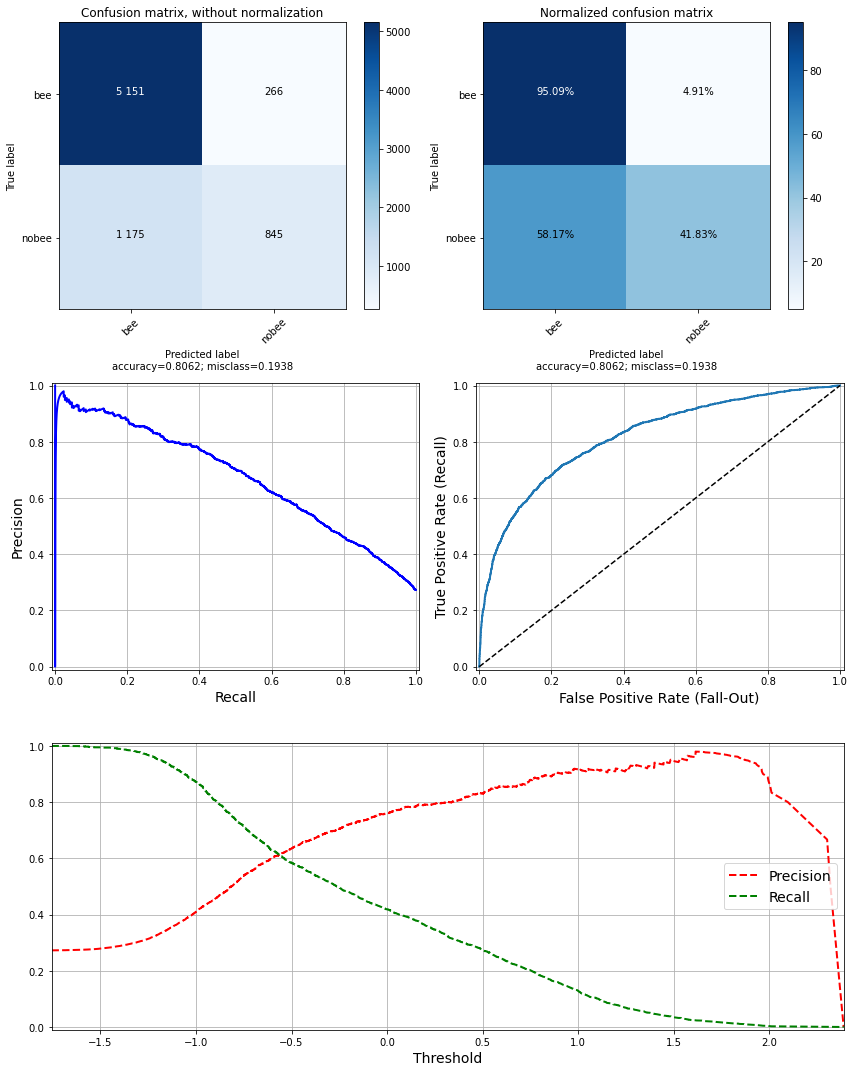

------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         bee       0.81      0.95      0.88      5417
       nobee       0.76      0.42      0.54      2020

    accuracy                           0.81      7437
   macro avg       0.79      0.68      0.71      7437
weighted avg       0.80      0.81      0.79      7437

------------------------------------------------------------------------------------------
Area Under ROC Curve 0.8161730489090999
------------------------------------------------------------------------------------------


In [9]:
from audace.plotters import clf_full_report
from sklearn import metrics

target_names = ['bee', 'nobee']

tst = int(100*TEST_FRAC)
trn = 100 -tst

figure_name = F"Full Report {KERNEL} - ({DATASET_NAME}) - [Trn{trn:02d},Tst{tst:02d}] - C{C}"
if KERNEL != 'linear':
    figure_name += F" - G{GAMMA}"

clf_full_report(clf, X_test, y_test, target_names, EXP_NAME, figure_name)


print("------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test, y_pred , target_names=target_names))
print("------------------------------------------------------------------------------------------")
print('Area Under ROC Curve', metrics.roc_auc_score(y_test, clf.decision_function(X_test)))
print("------------------------------------------------------------------------------------------")